# Иморт библиотек

In [274]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, optimizers, losses, metrics
from copy import deepcopy
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow.keras import regularizers
import os
import re
from unidecode import unidecode
from sklearn.preprocessing import KBinsDiscretizer
from fuzzywuzzy import process
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import json
import torch.nn.functional as F
import torch
from joblib import Memory
from tqdm.auto import tqdm
from nltk.stem.snowball import SnowballStemmer

from torch import Tensor
from transformers import AutoTokenizer, AutoModel

import tensorflow as tf
print("Версия TensorFlow:", tf.__version__)
print("GPU доступны:", tf.config.list_physical_devices('GPU'))
print("CuDNN версия:", tf.sysconfig.get_build_info()['cudnn_version'])

# Настройка кеширования
cache_dir = './neo_embeddings_cache'
os.makedirs(cache_dir, exist_ok=True)
memory = Memory(cache_dir, verbose=0)

stemmer = SnowballStemmer("russian")

Версия TensorFlow: 2.10.0
GPU доступны: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CuDNN версия: 8


# Преданализ

In [275]:
data = pd.read_csv("./data/train.csv")

In [276]:
data.head()

,title,location,company,skills,description,experience_from,salary_from,log_salary_from
0,Специалист технической поддержки,Воронеж,ВКТМ,NaN,Обязанности: Обеспечение бесперебойной раб...,1.0,60.0,4.094345
1,Product Owner в ИТ-стартап (B2C),Москва,Radium Finance,"CustDev, Стратегический менеджмент, Управление...","Эта вакансия про тебя, если симбиоз управленче...",6.0,200.0,5.298317
2,Системный администратор ( Клинический Госпитал...,Москва,Медскан,NaN,АО «Медскан» – динамично развивающаяся группа ...,1.0,130.0,4.867534
3,Системный Администратор Linux,Москва,Selecty,"Linux, PostgreSQL",Задачи: Администрирование инфраструктуры н...,3.0,170.0,5.135798
4,Начальник участка общестроительных работ,Пушкино (Московская область),NK GROUP,NaN,NK Group – ведущий девелопер индустриальных о...,3.0,200.0,5.298317


In [277]:
len(data)

16667

In [278]:
data['location'] = data['location'].fillna('неизвестно')
data['location'] = data['location'].apply(preprocess_location)
city_replacements = {
    'Зеленоград': 'Москва',
    'Орел': 'Орёл',
    'Королев': 'Королёв',
    'Другое': 'Неизвестно',
    'неизвестно': 'Неизвестно',
    'Вся РФ': 'Неизвестно',
    'удаленно': 'Неизвестно',
    'Россия': 'Неизвестно',
    'Обь': 'Неизвестно',
    'Анна': 'Неизвестно',
    'Ленинский )': 'Ленинский'
}
data['location'] = data['location'].replace(city_replacements)

In [279]:
print(data['location'].unique())

['Воронеж' 'Москва' 'Пушкино' 'Ачинск' 'Красноярск' 'Санкт-Петербург'
 'Челябинск' 'Пермь' 'Белорецк' 'Пятигорск' 'Казань' 'Чита' 'Екатеринбург'
 'Самара' 'Уссурийск' 'Саратов' 'Курск' 'Неизвестно' 'Краснодар'
 'Ленинский' 'Барнаул' 'Тула' 'Магнитогорск' 'Белгород' 'Новосибирск'
 'Пенза' 'Комсомольск-на-Амуре' 'Симферополь' 'Тюмень' 'Белая Калитва'
 'Калининград' 'Тверь' 'Балашиха' 'Фрязино' 'Севастополь' 'Нижнекамск'
 'Астрахань' 'Усть-Илимск' 'Нижний Новгород' 'Омск' 'Владивосток'
 'Ростов-на-Дону' 'Уфа' 'Киров' 'Рязань' 'Волгоград' 'Томск' 'Кашира'
 'Набережные Челны' 'Воткинск' 'Кемерово' 'Курган' 'Подольск' 'Ижевск'
 'Сочи' 'Тамбов' 'Новокузнецк' 'Орехово-Зуево' 'Тольятти' 'Владимир'
 'Торжок' 'Иркутск' 'Хабаровск' 'Муром' 'Жердевка' 'Ставрополь' 'Брянск'
 'Кострома' 'Полтавская' 'Архангельск' 'Липецк' 'Волгодонск' 'Махачкала'
 'Иваново' 'Йошкар-Ола' 'Ярославль' 'Братск' 'Кореновск' 'Ульяновск'
 'Волжский' 'Серпухов' 'Донецк' 'Вологда' 'Губкин' 'Нижний Тагил' 'Дубна'
 'Абакан' 'Се

In [280]:
cities_df = pd.read_csv('./data/cities.csv')

In [281]:
city_info = cities_df.set_index('location').to_dict(orient='index')
data['population'] = data['location'].apply(lambda x: city_info.get(x, {}).get('population'))
data['region'] = data['location'].apply(lambda x: city_info.get(x, {}).get('region'))

In [282]:
zlp = pd.read_excel('./data/sub2mean_zpl.xlsx')
zlp.head()

,"Среднемесячная номинальная начисленная заработная плата работников по полному кругу организаций по субъектам Российской Федерации в 2013-2018 гг., рублей",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,январь,февраль,март,апрель,май,июнь,июль,август,сентябрь,...,март,апрель,май,июнь,июль,август,сентябрь,октябрь,ноябрь,декабрь
3,Российская Федерация,26840.1,26619.6,28692.9,30025.9,29723,30986.1,30228.7,29226.3,29345.5,...,42363.573197,43381.051689,44075.537537,45848.077648,42413.465177,41363.600671,41774.303366,42331.668715,42595.00533,55569.330224
4,Центральный федеральный округ,32118.1,32249.7,35164.6,37138,35546.7,37723,37394,35277.9,35156.4,...,53771.108479,56192.142999,53566.574932,58177.204035,52984.806847,51383.060017,51529.217602,52715.114811,52642.495123,71661.794213


In [283]:
def create_region_mapping(data_regions, zlp_regions):
    """
    Создает словарь соответствий регионов из данных и таблицы zlp.
    """
    region_mapping = {}
    for region in data_regions:
        if pd.isna(region):
            region_mapping[region] = None
        else:
            match, score = process.extractOne(region, zlp_regions)
            region_mapping[region] = match if score > 80 else None  # Порог схожести (можно настроить)
    return region_mapping

In [284]:
def create_final_salary_dict(data, zlp):
    """
    Создает финальный словарь, который сопоставляет регионы из данных с их средней зарплатой.
    """
    # Обработка данных из zlp
    zlp = zlp.dropna(how='all')
    zlp = zlp.dropna(axis=1, how='all')
    zlp.columns = zlp.iloc[2]
    zlp = zlp[3:]
    zlp = zlp.rename(columns={zlp.columns[0]: 'region'})
    zlp = zlp.melt(id_vars=['region'], var_name='month_year', value_name='salary')
    zlp['salary'] = pd.to_numeric(zlp['salary'], errors='coerce')
    zlp = zlp.dropna(subset=['salary'])
    region_salary = zlp.groupby('region')['salary'].mean().reset_index()
    region_salary = region_salary.rename(columns={'salary': 'mean_salary'})
    region_salary_dict = region_salary.set_index('region')['mean_salary'].to_dict()
    
    # Уникальные регионы из данных
    data_regions = data['region'].unique()
    
    # Создаем словарь соответствий
    region_mapping = create_region_mapping(data_regions, list(region_salary_dict.keys()))
    
    # Создаем финальный словарь зарплат
    final_salary_dict = {}
    for region in data_regions:
        matched_region = region_mapping.get(region)
        if matched_region:
            final_salary_dict[region] = region_salary_dict.get(matched_region)
        else:
            final_salary_dict[region] = None  # Если регион не найден
    
    return final_salary_dict

In [285]:
# import json

# # Создание финального словаря зарплат
# final_salary_dict = create_final_salary_dict(data, zlp)

# # Сохранение словаря в файл
# with open('./data/region_salary_mapping.json', 'w', encoding='utf-8') as f:
#     json.dump(final_salary_dict, f, ensure_ascii=False, indent=4)

In [286]:
len([preprocess_location(row) for row in data['location'] if preprocess_location(row) == 'Вся РФ'])

0

In [287]:
len([d for d in data['company'].unique()])

9866

In [288]:
len([d for d in data['location'].unique()])

467

In [289]:
[print(d) for d in data['skills'][:10].unique()]

nan
CustDev, Стратегический менеджмент, Управление стейкхолдерами, Управление ожиданиями, Управление командой, Постановка задач разработчикам, Product-market fit, Customer Journey Mapping, User Story Mapping, Управление бэклогом, Управление ресурсами
Linux, PostgreSQL
Agile Project Management, Бизнес-анализ, Scrum, Управление портфелем продуктов, Продуктовая стратегия, Интервьюирование, Анализ бизнес-процессов, Разработка функциональных требований
SQL, 1С, Администрирование, Тестирование
Adobe Photoshop, Графические редакторы, Adobe Illustrator, 3D Моделирование, 3ds Max, Графика, Художник, 3D Max, Design, 3D-графика, Unity, Blender 3D, Autodesk Maya, Blender, Gamedev, Unreal Engine, UE4, UI, Animation, Photoshop, 3D, Motion design, Sketch, 3D Studio Max, Визуализация, ZBrush, Unity 3D, Adobe, Текстурирование


[None, None, None, None, None, None]

In [290]:
[print(len(d)) for d in data['description'][:10].unique()]

1732
4394
2224
808
1624
1113
1117
2065
1483
1799


[None, None, None, None, None, None, None, None, None, None]

# Конфигурационный файл

In [430]:
# Конфигурация
CONFIG = {
    "data_paths": {
        "train": "./data/train.csv",
        "test": "./data/test.csv"
    },
    "model_params": {
        "max_words": 20000,
        # "num_transformer_layers": 1,
        # "ffn_dim": 64,
        "max_len": 512,
        "embedding_dim": 128,
        "conv_filters": 128,
        "dense_units": 128,
        # "neo_embedding_size": 768,
        # "neo_projection_size": 64,
        "dropout_rate": 0.1,
        "batch_size": 16,
        "epochs": 50,
        "learning_rate": 0.001,
        "checkpoint_path": "./best_model.h5",
        "lr_scheduler": {
            "use_custom": False,
            "reduce_params": {
                "monitor": "val_loss",
                "min_lr": 1e-6,
                "verbose": 1,
                "patience": 5,
                "factor": 0.9 
            }
            # "reduce_params": {
            #     "base_lr": 1e-5,
            #     "max_lr": 1e-3,
            #     "step_size": 2000,
            #     "mode": 'triangular',
            #     "gamma": 1.0
            # }
        }
    },
    "output_path": "./submission.csv"
}

# 40%
# 512 128 128 128 0.1 = 0.05524
# 1024 128 128 128 0.1 = 0.05141
# 1024 128 128 128 0.2 = 0.05393
# 1024 128 128 256 768 0.2 = 0.05957 (population + region + mean_salary + llm_embedding)
# 1024 128 128 512 768 0.2 = 0.05850 (population + region + mean_salary + llm_embedding)
# 1024 128 128 1024 768 0.2 = 0.06050 (population + region + mean_salary + llm_embedding)
# 1024 128 128 128 768 0.1 = 0.06 (arch ver 2)
# 1024 64 64 64 768 0.1 =  (arch ver 2)
# 1024 128 128 128 0.2 = 0.0540 (population + region + mean_salary)
# 1024 128 128 128 0.2 = 0.16 (Weighted_mse_loss with bins = 10)
# 1024 128 128 128 0.2 = 0.05888 (Huber_loss = 1.0)
# 1024 128 128 128 0.5 = 0.08145
# 1024 128 128 128 0.1 = 0.06429 (not description)
# 2048 128 128 128 0.1 = 0.05218
# 4048 128 128 128 0.1 = 0.05341
# 4048 256 256 256 0.1 = 0.05222
# 4048 512 512 512 0.1 = 0.05416

# Работа с данными

In [353]:
import re

def preprocess_location(location: str) -> str:
    if not location:
        return 'Другое'

    # Удаление информации о метро
    location = re.sub(r'\(м\..*?\)', '', location, flags=re.IGNORECASE)
    location = re.sub(r'\(метро.*?\)', '', location, flags=re.IGNORECASE)
    location = re.sub(r'м\..*', '', location, flags=re.IGNORECASE)

    # Удаление информации о странах и других нерелевантных данных в скобках
    location = re.sub(r'\(.*?(область|край|республика|район|АО|Югра|Сербия|Армения|Узбекистан|Беларусь).*?\)', '', location, flags=re.IGNORECASE)

    # Удаление лишних пробелов и запятых
    location = re.sub(r'\s*,\s*.*', '', location)  # Удаляем всё после запятой
    location = re.sub(r'\s+', ' ', location).strip()  # Удаляем лишние пробелы

    # Удаляем "Московская область", сохраняя остальной текст
    location = re.sub(r'\s*\(?Московская область\)?\s*', ' ', location, flags=re.IGNORECASE).strip()
    location = re.sub(r'\s*\(?Кировская область\)?\s*', ' ', location, flags=re.IGNORECASE).strip()

    # Стандартизация названий
    replacements = {
        r'Санкт-Петербург.*': 'Санкт-Петербург',
        r'Москва.*': 'Москва',
        r'неизвестно': 'Другое',
        r'.*Республика Саха \(Якутия\).*': 'Якутия',
    }

    for pattern, replacement in replacements.items():
        if re.search(pattern, location, re.IGNORECASE):
            return replacement

    # Возврат результата
    return location if location else 'Другое'

def normalize_region(region):
    if pd.isna(region):  # Проверка на NaN или None
        return None
    
    # Удаляем лишние символы: [b], [c], [2], [3], \xa0 и другие
    region = re.sub(r'\[.*?\]', '', region)  # Удаляем всё в квадратных скобках
    region = re.sub(r'\\xa0', ' ', region)  # Заменяем \xa0 на пробел
    region = re.sub(r'\s+', ' ', region).strip()  # Убираем лишние пробелы
    
    # Замены для устаревших или неправильных названий
    replacements = {
        'Республика Крым/Автономная Республика Крым': 'Республика Крым',
        'город федерального значения Севастополь/Севастопольский городской совет': 'Севастополь',
        'Кемеровская область — Кузбасс': 'Кемеровская область',
        'Республика Саха (Якутия)': 'Якутия',
        'Чувашская Республика': 'Чувашия',
        'Республика Башкортостан': 'Башкортостан',
        'Республика Татарстан': 'Татарстан',
        'Республика Коми': 'Коми',
        'Республика Карелия': 'Карелия',
        'Республика Алтай': 'Алтай',
        'Северная Осетия — Алания': 'Северная Осетия',
        'Чеченская Республика': 'Чечня',
        'Запорожская': 'Запорожская область',
        'Херсонская': 'Херсонская область',
        'Донецкая область': 'Донецкая область',
        'Луганская область': 'Луганская область'
    }
    
    # Применяем замены
    for old, new in replacements.items():
        if old in region:
            region = new
            break
    
    return region

def match_region(region, region_list):
    """
    Находит наиболее похожее название региона из списка.
    """
    if pd.isna(region):
        return None
    match, score = process.extractOne(region, region_list)
    return match if score > 70 else None  # Порог схожести (можно настроить)

In [354]:
def clean_description(text: str) -> str:
    # Удаление всех специальных символов кроме букв и пробелов
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', ' ', text)
    
    # Приведение к нижнему регистру
    text = text.lower()
    
    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()

    text = re.sub(r'\W', ' ', text)
    words = [stemmer.stem(word) for word in text.split() if len(word) > 2]
    
    return ' '.join(words)

In [355]:
# @memory.cache
# def generate_neo_embeddings(texts, batch_size=32, max_length=512):
#     """
#     Генерация эмбеддингов для списка текстов с использованием NeoBERT.
#     Результаты кешируются для ускорения повторных запусков.
#     Возвращает numpy массив с эмбеддингами.
#     """

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")
    
#     model_name = "chandar-lab/NeoBERT"
#     tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
#     model = AutoModel.from_pretrained(model_name, trust_remote_code=True)

#     # Перемещаем модель на GPU (если доступен)
#     model.to(device)
    
#     embeddings = []
#     model.eval()  # Переводим модель в режим инференса

#     with torch.no_grad():  # Отключаем вычисление градиентов
#         for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
#             batch = texts[i:i + batch_size]
            
#             # Токенизация батча
#             inputs = tokenizer(
#                 batch, 
#                 return_tensors="pt", 
#                 padding=True, 
#                 truncation=True, 
#                 max_length=max_length  # Максимальная длина текста
#             )
            
#             # Перемещаем входные данные на GPU
#             inputs = {key: value.to(device) for key, value in inputs.items()}
            
#             # Генерация эмбеддингов
#             outputs = model(**inputs)
#             batch_embeddings = outputs.last_hidden_state[:, 0, :]  # Берем эмбеддинг первого токена [CLS]
            
#             # Перемещаем эмбеддинги обратно на CPU и преобразуем в numpy
#             embeddings.append(batch_embeddings.cpu().numpy())
    
#     return np.concatenate(embeddings, axis=0)

In [394]:
def load_and_preprocess_data():
    
    # Загрузка данных
    train_data = pd.read_csv(CONFIG["data_paths"]["train"])
    test_data = pd.read_csv(CONFIG["data_paths"]["test"])
    cities_df = pd.read_csv('./data/cities.csv')
    zlp = pd.read_excel('./data/sub2mean_zpl.xlsx')
    # Загрузка словаря из файла
    with open('./data/region_salary_mapping.json', 'r', encoding='utf-8') as f:
        final_salary_dict = json.load(f)
    
    # Нормализация числовых признаков
    scaler = StandardScaler()
    train_data['experience_from'] = scaler.fit_transform(train_data[['experience_from']])
    test_data['experience_from'] = scaler.transform(test_data[['experience_from']])
    
    # Обработка локаций
    for df in [train_data, test_data]:
        df['location'] = df['location'].fillna('неизвестно')
        df['location'] = df['location'].apply(preprocess_location)
        city_replacements = {
            'Зеленоград': 'Москва',
            'Орел': 'Орёл',
            'Королев': 'Королёв',
            'Другое': 'Неизвестно',
            'неизвестно': 'Неизвестно',
            'Вся РФ': 'Неизвестно',
            'удаленно': 'Неизвестно',
            'Россия': 'Неизвестно',
            'Обь': 'Неизвестно',
            'Анна': 'Неизвестно',
            'Ленинский )': 'Ленинский'
        }
        df['location'] = df['location'].replace(city_replacements)
        city_info = cities_df.set_index('location').to_dict(orient='index')
        df['population'] = df['location'].apply(lambda x: city_info.get(x, {}).get('population'))
        df['region'] = df['location'].apply(lambda x: city_info.get(x, {}).get('region'))
        df['region'] = df['region'].apply(normalize_region)
        df['mean_salary'] = df['region'].map(final_salary_dict)
        df['mean_salary'] = df['mean_salary'].fillna(0)

    train_data['population'] = train_data['population'].fillna(0)
    train_data['population'] = train_data['population'].apply(lambda x: 0 if x > 20000000 else x)
    test_data['population'] = test_data['population'].fillna(0)
    test_data['population'] = test_data['population'].apply(lambda x: 0 if x > 20000000 else x)
    train_data['population'] = scaler.fit_transform(train_data[['population']])
    test_data['population'] = scaler.transform(test_data[['population']])

    train_data['mean_salary'] = scaler.fit_transform(train_data[['mean_salary']])
    test_data['mean_salary'] = scaler.transform(test_data[['mean_salary']])

    # Кодирование региона
    region_encoder = LabelEncoder()
    all_regions = pd.concat([train_data['region'], test_data['region']]).fillna("Неизвестно")
    region_encoder.fit(all_regions)

    for df in [train_data, test_data]:
        df['region'] = region_encoder.transform(df['region'].fillna("Неизвестно"))

    # Кодирование локаций
    location_encoder = LabelEncoder()
    all_locations = pd.concat([train_data['location'], test_data['location']]).fillna("Неизвестно")
    location_encoder.fit(all_locations)

    for df in [train_data, test_data]:
        df['location'] = location_encoder.transform(df['location'].fillna("Неизвестно"))
    
    # Обработка описания
    for df in [train_data, test_data]:
        df['description'] = df['description'].fillna('')
        df['description'] = df['description'].apply(clean_description)

    # Генерация эмбеддингов для описаний с использованием NeoBERT
    # train_neo_emb = generate_neo_embeddings(train_data['description'].tolist(), batch_size=32, max_length=2048)
    # test_neo_emb = generate_neo_embeddings(test_data['description'].tolist(), batch_size=32, max_length=2048)
    
    # Токенизация текста
    tokenizer = Tokenizer(num_words=CONFIG['model_params']['max_words'])
    
    all_text = (
        train_data['title'].fillna('') + ' ' +
        train_data['company'].fillna('') + ' ' +
        train_data['skills'].fillna('') + ' ' +
        train_data['description'].fillna('')
    )
    
    tokenizer.fit_on_texts(all_text)

    return train_data, test_data, tokenizer, scaler
    # return train_data, test_data, tokenizer, scaler, train_neo_emb, test_neo_emb

In [380]:
# Визуализация распределения
def plot_distribution(series: pd.Series, title: str, bins: int = 10):
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(series, kde=True, bins=bins)
    
    metrics = {
        'Среднее': series.mean(),
        'Медиана': series.median(),
        '25-й квантиль': series.quantile(0.25),
        '75-й квантиль': series.quantile(0.75)
    }

    colors = ['red', 'green', 'blue', 'blue']
    
    for index, (label, value) in enumerate(metrics.items()):
        ax.axvline(value, linestyle='--', label=f"{label}: {value:.2f}", color=colors[index])
    
    plt.title(f'Распределение {title}')
    plt.xlabel('Значение')
    plt.ylabel('Частота')
    plt.legend()
    plt.grid(True)
    plt.show()

In [395]:
# Предобработка текста
def preprocess_text(df: pd.DataFrame) -> pd.Series:
    return (
        df['title'].fillna('') + ' ' +
        df['skills'].fillna('') + ' ' +
        df['company'].fillna('') + ' ' +
        df['description'].fillna('')
    )

# Модель

In [396]:
class CustomScheduler(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=1e-5, max_lr=1e-3, step_size=2000, mode='triangular', gamma=1.0):
        """
        Циклический Learning Rate.
        
        Параметры:
        -----------
        base_lr: float
            Нижняя граница LR.
        max_lr: float
            Верхняя граница LR.
        step_size: int
            Количество итераций для половины цикла.
        mode: str
            Режим изменения LR ('triangular', 'triangular2', 'exp_range').
        gamma: float
            Коэффициент затухания для 'exp_range'.
        """
        super().__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        self.iterations = 0
        self.history = {}

    def clr(self):
        """Вычисляет текущий Learning Rate."""
        cycle = np.floor(1 + self.iterations / (2 * self.step_size))
        x = np.abs(self.iterations / self.step_size - 2 * cycle + 1)
        
        if self.mode == 'triangular':
            lr = self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x))
        elif self.mode == 'triangular2':
            lr = self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) / float(2 ** (cycle - 1))
        elif self.mode == 'exp_range':
            lr = self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * (self.gamma ** self.iterations)
        else:
            raise ValueError("Режим должен быть 'triangular', 'triangular2' или 'exp_range'")
        
        return lr

    def on_train_begin(self, logs=None):
        """Инициализация при начале обучения."""
        if self.iterations == 0:
            self.model.optimizer.lr.assign(self.base_lr)
        logs = logs or {}
        self.history.setdefault('lr', [])

    def on_batch_end(self, batch, logs=None):
        """Обновление LR после каждого батча."""
        logs = logs or {}
        self.iterations += 1
        lr = self.clr()
        self.model.optimizer.lr.assign(lr)
        self.history['lr'].append(lr)
        logs['lr'] = lr

In [420]:
# def create_model_inputs(config):
#     # Текстовый вход
#     text_input = layers.Input(shape=(config['max_len'],), name='text_input')
    
#     # Числовой вход
#     numeric_input = layers.Input(shape=(4,), name='numeric_input')  # 4 признака

#     # Вход для NeoBERT эмбеддингов
#     # neo_input = layers.Input(shape=(config['neo_embedding_size'],), name='neo_input')
    
#     # Текстовая ветвь
#     x = layers.Embedding(config['max_words'], config['embedding_dim'])(text_input)
#     x = layers.Conv1D(config['conv_filters'], 3, padding='same', activation='relu')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)
#     x = layers.Dropout(config['dropout_rate'])(x)
#     text_output = layers.GlobalMaxPooling1D()(x)
    
#     # Обработка NeoBERT эмбеддингов
#     # x_neo = layers.Reshape((config['neo_embedding_size'], 1))(neo_input)  # Добавляем временную ось
#     # x_neo = layers.Conv1D(config['conv_filters'], 3, padding='same', activation='relu')(x_neo)
#     # x_neo = layers.BatchNormalization()(x_neo)
#     # x_neo = layers.ReLU()(x_neo)
#     # x_neo = layers.Dropout(config['dropout_rate'])(x_neo)
#     # neo_output = layers.GlobalMaxPooling1D()(x_neo)
    
#     # Объединение всех признаков
#     merged = layers.concatenate([text_output, numeric_input])
#     # merged = layers.concatenate([text_output, numeric_input, neo_output])
    
#     # Регрессионная ветвь
#     x = layers.Dense(config['dense_units'], activation='relu')(merged)
#     x = layers.Dropout(config['dropout_rate']/2)(x)
#     output = layers.Dense(1)(x)

#     return models.Model(
#         inputs=[text_input, numeric_input], 
#         outputs=output
#     )
    
#     # return models.Model(
#     #     inputs=[text_input, numeric_input, neo_input], 
#     #     outputs=output
#     # )


def create_model_inputs(config):
    # Входы
    text_input = layers.Input(shape=(config['max_len'],), name='text_input')
    numeric_input = layers.Input(shape=(3,), name='numeric_input')
    
    # Текстовая ветвь
    x = layers.Embedding(config['max_words'], config['embedding_dim'])(text_input)
    x = layers.Bidirectional(layers.LSTM(config['conv_filters'], return_sequences=True))(x)
    x = layers.LayerNormalization()(x)
    x = layers.GlobalMaxPool1D()(x)
    
    # Числовая ветвь
    y = layers.Dense(config['dense_units'], activation='relu')(numeric_input)
    y = layers.BatchNormalization()(y)
    
    # Объединение
    merged = layers.Concatenate()([x, y])
    merged = layers.Dense(config['dense_units'], activation='relu')(merged)
    
    output = layers.Dense(1)(merged)
    
    return models.Model(inputs=[text_input, numeric_input], outputs=output)


# def create_model_inputs(config):
#     # Входы
#     text_input = layers.Input(shape=(config['max_len'],), name='text_input')
#     numeric_input = layers.Input(shape=(3,), name='numeric_input')
    
#     # Текстовая ветвь
#     x = layers.Embedding(config['max_words'], output_dim=config['embedding_dim'], name='text_embedding')(text_input)
#     x = layers.Conv1D(config['conv_filters'], kernel_size=3, padding='same', activation='relu')(x)
#     # x = layers.SpatialDropout1D(config['dropout_rate'])(x)
#     # x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
#     x = layers.LayerNormalization()(x)
#     x = layers.GlobalMaxPool1D()(x)
    
#     # Числовая ветвь
#     y = layers.Dense(config['dense_units'], activation='relu', kernel_regularizer='l2')(numeric_input)
#     y = layers.BatchNormalization()(y)
#     y = layers.Dropout(config['dropout_rate'])(y)

#     # Объединение
#     merged = layers.Concatenate()([x, y])
#     merged = layers.Dense(config['dense_units'], activation='relu', kernel_regularizer='l2')(merged)
#     merged = layers.BatchNormalization()(merged)
#     merged = layers.Dropout(config['dropout_rate'])(merged)
    
#     # Выход
#     output = layers.Dense(1)(merged)
    
#     return models.Model(inputs=[text_input, numeric_input], outputs=output)


# def create_model_inputs(config):
#     # Входные слои
#     text_input = layers.Input(shape=(config['max_len'],), name='text_input')
#     numeric_input = layers.Input(shape=(4,), name='numeric_input')
    
#     # 1. Улучшенная трансформерная ветвь
#     x = layers.Embedding(
#         input_dim=config['max_words'],
#         output_dim=config['embedding_dim'],
#         embeddings_regularizer=regularizers.l2(1e-4)  # Увеличили регуляризацию
#     )(text_input)
    
#     # Синусоидальное позиционное кодирование
#     positions = PositionalEncoding(config['max_len'], config['embedding_dim'])(x)
#     x = x + positions
    
#     # 2-х слойный трансформер
#     for _ in range(1):  # Добавили глубины
#         # Self-attention с увеличенным dropout
#         attn = layers.MultiHeadAttention(
#             num_heads=24,
#             key_dim=config['embedding_dim'] // 4,
#             dropout=0.5  # Увеличили dropout
#         )(x, x)
#         x = layers.LayerNormalization()(x + attn)
        
#         # FFN с правильной размерностью
#         ffn = layers.Dense(config['embedding_dim'] * 4, activation='gelu')(x)
#         ffn = layers.Dropout(0.5)(ffn)  # Увеличили dropout
#         ffn = layers.Dense(config['embedding_dim'])(ffn)
#         x = layers.LayerNormalization()(x + ffn)
    
#     # Пулинг с объединением методов
#     x = layers.Concatenate()([
#         layers.GlobalMaxPooling1D()(x),
#         layers.GlobalAveragePooling1D()(x)
#     ])
    
#     # 2. Числовая ветвь с уменьшенной емкостью
#     y = layers.Dense(128, activation='relu')(numeric_input)  # Уменьшили нейроны
#     y = layers.BatchNormalization()(y)
#     y = layers.Dropout(0.5)(y)  # Увеличили dropout
    
#     # 3. Объединение с нормализацией
#     merged = layers.Concatenate()([x, y])
#     merged = layers.BatchNormalization()(merged)
    
#     # 4. Эксперты с контролируемой емкостью
#     expert1 = layers.Dense(128, activation='gelu', kernel_regularizer=regularizers.l2(1e-4))(merged)
#     expert1 = layers.Dropout(0.5)(expert1)
    
#     expert2 = layers.Dense(128, activation='swish', kernel_regularizer=regularizers.l2(1e-4))(merged)
#     expert2 = layers.Dropout(0.5)(expert2)
    
#     # Упрощенный gating механизм
#     gate = layers.Dense(1, activation='sigmoid')(merged)  # Бинарный выбор
#     merged = layers.Lambda(
#         lambda x: x[0] * x[1] + (1 - x[0]) * x[2]
#     )([gate, expert1, expert2])
    
#     # Финальные слои с регуляризацией
#     merged = layers.Dense(32, activation='relu')(merged)
#     merged = layers.Dropout(0.5)(merged)
    
#     output = layers.Dense(1)(merged)
    
#     return models.Model(
#         inputs=[text_input, numeric_input],
#         outputs=output
#     )

# class PositionalEncoding(layers.Layer):
#     def __init__(self, max_len, d_model, **kwargs):
#         super().__init__(**kwargs)
#         self.max_len = max_len
#         self.d_model = d_model
#         self.position = np.arange(max_len)[:, np.newaxis]
#         self.div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        
#     def build(self, input_shape):
#         pe = np.zeros((self.max_len, self.d_model))
#         pe[:, 0::2] = np.sin(self.position * self.div_term)
#         pe[:, 1::2] = np.cos(self.position * self.div_term)
#         self.pe = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)
#         super().build(input_shape)
        
#     def call(self, x):
#         return self.pe[:, :tf.shape(x)[1], :]
    
#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             'max_len': self.max_len,
#             'd_model': self.d_model
#         })
#         return config


# def create_model_inputs(config):
#     # Текстовый вход
#     text_input = layers.Input(shape=(config['max_len'],), name='text_input')
    
#     # Числовой вход
#     numeric_input = layers.Input(shape=(4,), name='numeric_input')  # 4 признака
    
#     # Текстовая ветвь (комбинация CNN + LSTM)
#     x = layers.Embedding(
#         input_dim=config['max_words'],
#         output_dim=config['embedding_dim'],
#         mask_zero=True  # Для обработки паддинга
#     )(text_input)
    
#     # CNN часть для локальных паттернов
#     x = layers.Conv1D(
#         filters=config['conv_filters'],
#         kernel_size=3,
#         padding='same',
#         activation='relu'
#     )(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling1D(pool_size=2)(x)
#     x = layers.Dropout(config['dropout_rate'])(x)
    
#     # LSTM часть для временных зависимостей
#     x = layers.Bidirectional(
#         layers.LSTM(
#             units=64,  # Добавляем новый параметр в config
#             return_sequences=False,
#             dropout=config['dropout_rate']*0.5,
#             recurrent_dropout=0
#         )
#     )(x)
#     text_output = layers.BatchNormalization()(x)
    
#     # Объединение всех признаков
#     merged = layers.concatenate([text_output, numeric_input])
    
#     # Регрессионная ветвь с дополнительной регуляризацией
#     x = layers.Dense(
#         config['dense_units'],
#         activation='relu',
#         kernel_regularizer=tf.keras.regularizers.l2(0.01)
#     )(merged)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(config['dropout_rate'])(x)
    
#     # Выходной слой для регрессии
#     output = layers.Dense(1, kernel_initializer='glorot_normal')(x)

#     return models.Model(
#         inputs=[text_input, numeric_input], 
#         outputs=output
#     )


# def create_model_inputs(config):
#     # Текстовый вход
#     text_input = layers.Input(shape=(config['max_len'],), name='text_input')
    
#     # Числовой вход с расширенной обработкой
#     numeric_input = layers.Input(shape=(4,), name='numeric_input')
    
#     # Вход для NeoBERT эмбеддингов
#     neo_input = layers.Input(shape=(config['neo_embedding_size'],), name='neo_input')

#     # 1. Расширенная текстовая обработка (Hybrid Transformer-CNN)
#     # ----------------------------------------------------------
#     x_text = layers.Embedding(config['max_words'], config['embedding_dim'])(text_input)
    
#     # Transformer Block
#     for _ in range(config['num_transformer_layers']):
#         # Self-attention
#         attn_output = layers.MultiHeadAttention(
#             num_heads=8, key_dim=config['embedding_dim']//8)(x_text, x_text)
#         attn_output = layers.Dropout(config['dropout_rate'])(attn_output)
#         x_text = layers.LayerNormalization()(x_text + attn_output)
        
#         # FFN
#         ffn = layers.Dense(config['ffn_dim'], activation='gelu')(x_text)
#         ffn = layers.Dropout(config['dropout_rate'])(ffn)
#         x_text = layers.LayerNormalization()(x_text + ffn)
    
#     # Depthwise Separable Conv для локальных паттернов
#     conv_output = layers.SeparableConv1D(
#         filters=config['conv_filters'], kernel_size=3, padding='same')(x_text)
#     conv_output = layers.GlobalMaxPooling1D()(conv_output)

#     # 2. Обработка NeoBERT эмбеддингов (Projection + Gating)
#     # ------------------------------------------------------
#     x_neo = layers.Dense(config['neo_projection_size'], activation='gelu')(neo_input)
#     x_neo = layers.LayerNormalization()(x_neo)
    
#     # Gating механизм
#     gate = layers.Dense(config['neo_projection_size'], activation='sigmoid')(neo_input)
#     x_neo = layers.Multiply()([x_neo, gate])

#     # 3. Расширенная обработка числовых признаков
#     # --------------------------------------------
#     x_num = layers.Dense(32, activation='gelu')(numeric_input)
#     x_num = layers.LayerNormalization()(x_num)
#     x_num = layers.Dense(64, activation='gelu')(x_num)
    
#     # 4. Кросс-модальное взаимодействие (Cross-Attention)
#     # ---------------------------------------------------
#     # Преобразуем x_neo и conv_output в 3D-тензоры
#     x_neo_expanded = tf.expand_dims(x_neo, axis=1)  # (batch_size, 1, neo_projection_size)
#     conv_output_expanded = tf.expand_dims(conv_output, axis=1)  # (batch_size, 1, conv_filters)
#     cross_attn = layers.MultiHeadAttention(
#         num_heads=4, key_dim=64)(x_neo_expanded, conv_output_expanded)
#     cross_attn = layers.GlobalAveragePooling1D()(cross_attn)
    
#     # 5. Объединение признаков с Feature-wise Modulation
#     # --------------------------------------------------
#     merged = layers.concatenate([conv_output, x_neo, x_num, cross_attn])
    
#     # FiLM (Feature-wise Linear Modulation)
#     film_params = layers.Dense(merged.shape[-1] * 2)(x_num)
#     film_gamma = film_params[:, :merged.shape[-1]]
#     film_beta = film_params[:, merged.shape[-1]:]
#     merged = layers.Multiply()([merged, film_gamma]) + film_beta

#     # 6. Иерархическая декомпозиция признаков
#     # ----------------------------------------
#     dense_num = config['dense_units']
#     for units in [dense_num, dense_num // 2, dense_num // 4]:
#         residual = merged
#         merged = layers.Dense(units, activation='gelu')(merged)
#         merged = layers.LayerNormalization()(merged)
#         merged = layers.Dropout(config['dropout_rate'])(merged)
#         merged = layers.Dense(units*2, activation='gelu')(merged)
#         merged = layers.LayerNormalization()(merged)

#         # Проекция residual, если размерности не совпадают
#         if residual.shape[-1] != merged.shape[-1]:
#             residual = layers.Dense(merged.shape[-1])(residual)
            
#         merged = residual + merged  # Skip-connection
#         merged = layers.Dropout(config['dropout_rate'])(merged)
    
#     # 7. Динамическая регуляризация
#     # -----------------------------
#     output = layers.Dense(1)(merged)
#     output = layers.Dropout(config['dropout_rate']/2)(output)
    
#     return models.Model(
#         inputs=[text_input, numeric_input, neo_input],
#         outputs=output
#     )

In [406]:
def get_callbacks(config):
    callback_list = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=config['checkpoint_path'],
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    if config['lr_scheduler']['use_custom']:
        callback_list.append(CustomScheduler(**config['lr_scheduler']['reduce_params']))
    else:
        callback_list.append(tf.keras.callbacks.ReduceLROnPlateau(**config['lr_scheduler']['reduce_params']))
    
    return callback_list

# Обучение

In [407]:
# Визуализация истории обучения
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    metrics = ['loss', 'mean_squared_error', 'mean_absolute_error', 'r_squared']
    
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        ax.plot(history.history[metric], label='Train')
        ax.plot(history.history[f'val_{metric}'], label='Validation')
        ax.set_title(metric.replace('_', ' ').title())
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        
        if 'r_squared' in metric.lower():
            ax.set_ylim(-0.1, 1.1)  # R² обычно в диапазоне [0, 1]
        
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

    # График изменения Learning Rate
    plt.figure(figsize=(10, 5))
    lr_history = history.history.get('lr', [])
    if lr_history:
        plt.plot(lr_history, label='Learning Rate')
        plt.title('Learning Rate Dynamics')
        plt.xlabel('Epoch')
        plt.ylabel('LR')
        plt.legend()
        plt.grid(True)
        plt.show()

In [408]:
from tensorflow.keras import metrics
import tensorflow.keras.backend as K

class RSquared(metrics.Metric):
    """R² (коэффициент детерминации) - метрика качества регрессии."""

    def __init__(self, name='r_squared', dtype=None, **kwargs):
        super(RSquared, self).__init__(name=name, dtype=dtype, **kwargs)
        self.total_sum_squares = self.add_weight(name='ss_tot', initializer='zeros')
        self.residual_sum_squares = self.add_weight(name='ss_res', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = K.cast(y_true, self.dtype)
        y_pred = K.cast(y_pred, self.dtype)

        y_true_mean = K.mean(y_true)
        ss_tot = K.sum(K.square(y_true - y_true_mean))
        ss_res = K.sum(K.square(y_true - y_pred))

        self.total_sum_squares.assign_add(ss_tot)
        self.residual_sum_squares.assign_add(ss_res)

    def result(self):
        return 1 - (self.residual_sum_squares / (self.total_sum_squares + K.epsilon()))

    def reset_state(self):
        self.total_sum_squares.assign(0.)
        self.residual_sum_squares.assign(0.)

In [409]:
from tensorflow.keras import losses
import tensorflow.keras.backend as K

class RSquaredLoss(losses.Loss):
    """Loss = 1 - R² (минимизируется, т.к. R² максимизируется)"""
    
    def __init__(self, name='r_squared_loss', **kwargs):
        super().__init__(name=name, **kwargs)
        
    def call(self, y_true, y_pred):
        y_true = K.cast(y_true, 'float32')
        y_pred = K.cast(y_pred, 'float32')
        
        y_true_mean = K.mean(y_true)
        ss_tot = K.sum(K.square(y_true - y_true_mean))
        ss_res = K.sum(K.square(y_true - y_pred))
        
        r2 = 1 - (ss_res / (ss_tot + K.epsilon()))
        return 1 - r2  # Минимизируем (1 - R²)

In [410]:
train_data, test_data, tokenizer, scaler = load_and_preprocess_data()

In [431]:
def main(train_data, test_data, tokenizer, scaler):

    split_size = 0.05
    bins_plot = 200
    # bins_weight = 200
    
    # Загрузка данных с NeoBERT эмбеддингами
    # train_data, test_data, tokenizer, scaler, train_neo_emb, test_neo_emb = load_and_preprocess_data()
    
    # Разделение данных
    train_df, val_df = train_test_split(train_data, test_size=split_size, random_state=42)

    # Подготовка NeoBERT эмбеддингов
    # X_train_neo = train_neo_emb[train_df.index]
    # X_val_neo = train_neo_emb[val_df.index]
    
    # Подготовка текстовых данных
    X_train_text = pad_sequences(
        tokenizer.texts_to_sequences(preprocess_text(train_df)),
        maxlen=CONFIG['model_params']['max_len']
    )
    X_val_text = pad_sequences(
        tokenizer.texts_to_sequences(preprocess_text(val_df)),
        maxlen=CONFIG['model_params']['max_len']
    )
    
    # Числовые признаки
    X_train_num = train_df[['experience_from', 'population', 'mean_salary']].values
    X_val_num = val_df[['experience_from', 'population', 'mean_salary']].values
    
    # Целевая переменная
    y_train = train_df['log_salary_from'].values
    y_val = val_df['log_salary_from'].values

    # Смотрим на распределение тренировочных данных по таргету
    plot_distribution(pd.Series(y_train), "Распределение таргетной переменной на тренировочной выборке", bins_plot)
    
    # Создание и обучение модели
    model = create_model_inputs(CONFIG['model_params'])
    callbacks = get_callbacks(CONFIG['model_params'])

    # Компиляция модели
    model.compile(
        optimizer=optimizers.Adam(learning_rate=CONFIG['model_params']['learning_rate']),
        loss=losses.Huber(delta=0.7), # weighted_mse_loss, # losses.Huber(delta=0.7) # RSquaredLoss()
        metrics=[
            metrics.MeanSquaredError(),
            metrics.MeanAbsoluteError(),
            RSquared()
        ]
    )
    
    # Передаем веса в model.fit
    history = model.fit(
        [X_train_text, X_train_num], y_train,
        validation_data=([X_val_text, X_val_num], y_val),
        epochs=CONFIG['model_params']['epochs'],
        batch_size=CONFIG['model_params']['batch_size'],
        callbacks=callbacks,
        verbose=1
    )

    # history = model.fit(
    #     [X_train_text, X_train_num, X_train_neo], y_train,
    #     validation_data=([X_val_text, X_val_num, X_val_neo], y_val),
    #     epochs=CONFIG['model_params']['epochs'],
    #     batch_size=CONFIG['model_params']['batch_size'],
    #     callbacks=callbacks,
    #     verbose=1
    # )

    # История обучения
    plot_training_history(history)
    
    # Загрузка лучшей модели
    best_model = models.load_model(
        CONFIG['model_params']['checkpoint_path'],
        custom_objects={'RSquared': RSquared, 'RSquaredLoss': RSquaredLoss}
    )
    
    # Подготовка тестовых данных
    X_test_text = pad_sequences(
        tokenizer.texts_to_sequences(preprocess_text(test_data)),
        maxlen=CONFIG['model_params']['max_len']
    )
    X_test_num = test_data[['experience_from', 'population', 'mean_salary']].values
    # X_test_neo = test_neo_emb
    
    # Предсказание
    predictions = best_model.predict([X_test_text, X_test_num]).flatten()
    # predictions = best_model.predict([X_test_text, X_test_num, X_test_neo]).flatten()

    # Смотрим на распределение предсказаний
    plot_distribution(pd.Series(predictions), "Распределение таргетной переменной на предсказаниях", bins_plot)
    
    # Сохранение результатов
    submission = pd.DataFrame({
        'index': test_data.index,
        'prediction': predictions
    })
    submission.to_csv(CONFIG['output_path'], index=False)

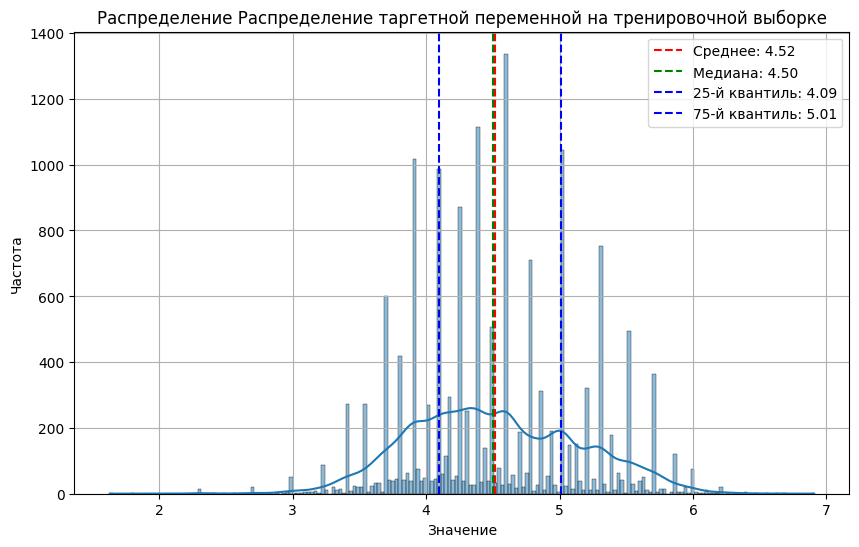

Epoch 1/50
159/990 [===>..........................] - ETA: 23s - loss: 0.1652 - mean_squared_error: 0.4667 - mean_absolute_error: 0.4730 - r_squared: -0.2421      

KeyboardInterrupt: 

In [432]:
main(train_data, test_data, tokenizer, scaler)

# Парсер

In [34]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import quote


def clean_population(population):
    if not population:
        return None
    
    # Удаляем числа в квадратных скобках (например, [2])
    population = re.sub(r'\[\d+\]', '', population)
    
    # Удаляем годы (например, 2024)
    population = re.sub(r'\b\d{4}\b', '', population)
    
    # Удаляем всё, кроме цифр и пробелов
    cleaned = re.sub(r'[^\d\s]', '', population)
    
    # Убираем неразрывные пробелы и лишние пробелы
    cleaned = cleaned.replace('\xa0', '').strip()
    cleaned = cleaned.replace(' ', '')
    
    # Преобразуем в целое число
    try:
        return int(cleaned)
    except ValueError:
        return None


def parse_wikipedia_population(location):
    # Кодируем название для URL
    encoded_location = quote(location)
    url = f"https://ru.wikipedia.org/wiki/{encoded_location}"
    
    # Настраиваем заголовки для имитации браузера
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Проверка на ошибки HTTP
        
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Поиск информационной таблицы
        infobox = soup.select_one('table.infobox')
        if not infobox:
            return {"error": "Инфобокс не найден"}

        type_city = None
        population = None
        region = None
        
        # Поиск данных в строках таблицы
        for index, row in enumerate(infobox.find_all('tr')):
            th = row.find('th')
            if th:
                th_text = th.get_text(strip=True)
                
                # Поиск населения
                if 'Население' in th_text:
                    td = row.find('td')
                    if td:
                        population = td.get_text(strip=True)
                        population = clean_population(population)
                        
                # Поиск региона (может отличаться в разных статьях)
                if any(word in th_text for word in ['Регион', 'Субъект', 'Область', 'Край']):
                    td = row.find('td')
                    if td:
                        region = td.get_text(strip=True)
        
        return {
            "location": location,
            "population": population,
            "region": region
        }
        
    except Exception as e:
        return {"error": str(e)}


def parse_info_cities(cities: pd.Series):
    results = []
    for city in cities:
        result = parse_wikipedia_population(city)
        results.append(result)
    # Преобразуем список словарей в DataFrame
    df = pd.DataFrame(results)
    return df

In [ ]:
# df_cities = parse_info_cities(pd.Series(cities).unique())

In [ ]:
# df_cities

In [ ]:
# df_cities.drop(df_cities[df_cities['error'].notna()].index, inplace=True)

In [ ]:
# df_cities = df_cities.drop(columns=['error'])

In [ ]:
# df_cities

In [ ]:
# df_cities.to_csv('./data/cities.csv', index=False)